# Feature Selection for Lending Club Data
## COMP647 Assignment 03
### Student ID: 1163127

This notebook implements feature selection techniques including:
- Univariate statistical tests (ANOVA, Chi-Square)
- Wrapper methods (Recursive Feature Elimination)
- Embedded methods (Random Forest importance)

Based on LAB5 materials and course teachings.

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Feature selection libraries
from sklearn.feature_selection import (
    SelectKBest, f_classif, chi2, 
    RFE, RFECV,
    SelectFromModel
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Load preprocessed data from previous notebooks
try:
    # Load the processed sample data
    df = pd.read_csv('../data/processed/accepted_sample_10000.csv')
    print(f"Data loaded successfully: {df.shape}")
    print(f"Columns: {len(df.columns)}")
    
    # Display basic info
    print("\nDataset Preview:")
    print(df.head())
    
    # Identify target variable
    target_column = 'loan_status' if 'loan_status' in df.columns else None
    if target_column:
        print(f"\nTarget variable: {target_column}")
        print(f"Target distribution:")
        print(df[target_column].value_counts())
    else:
        print("\nWarning: loan_status column not found")
        
except FileNotFoundError:
    print("Processed data not found. Please run Assignment 02 notebooks first.")
    df = pd.DataFrame()
    target_column = None

Data loaded successfully: (10000, 151)
Columns: 151

Dataset Preview:
         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade                    emp_title  \
0     13.99       123.03     C        C4                      leadman   
1     11.99       820.28     C        C1                     Engineer   
2     10.78       432.66     B        B4                 truck driver   
3     14.85       829.90     C        C5  Information Systems Officer   
4     22.45       289.91     F        F1          Contract Specialist   

  emp_length hom

## Univariate Statistical Tests
### ANOVA F-test for Numerical Features
Based on LAB5 materials - measures linear dependency between features and target

Dataset: 10000 samples, 15 features
Applying ANOVA F-test for numerical features...
Selected 10 features

Top 5 features:
  int_rate: F-score = 245.51
  loan_amnt: F-score = 109.04
  funded_amnt: F-score = 109.04
  funded_amnt_inv: F-score = 109.04
  fico_range_low: F-score = 36.99


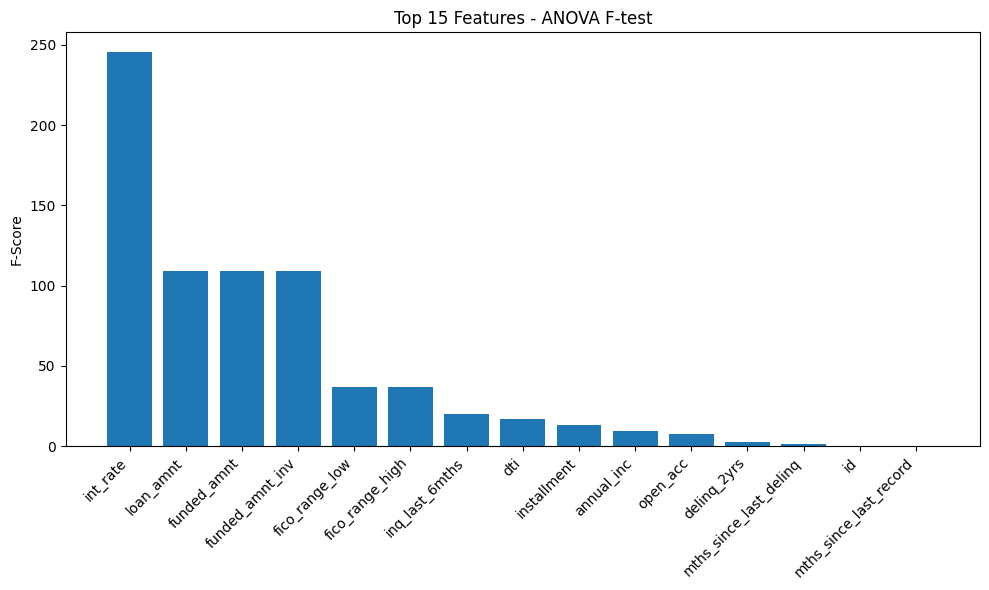

In [3]:
# ANOVA F-test Implementation
from sklearn.feature_selection import SelectKBest, f_classif

def apply_anova_ftest(X, y, k=10):
    """
    Apply ANOVA F-test for feature selection
    
    Parameters:
    X: DataFrame with numerical features (no NaN)
    y: target variable (classification)
    k: number of top features to select
    
    Returns:
    selected_features, results_df, selector
    """
    print("Applying ANOVA F-test for numerical features...")
    
    selector = SelectKBest(score_func=f_classif, k=min(k, X.shape[1]))
    selector.fit(X, y)
    
    # Get results
    results_df = pd.DataFrame({
        'feature': X.columns,
        'f_score': selector.scores_,
        'selected': selector.get_support()
    }).sort_values('f_score', ascending=False)
    
    selected_features = results_df[results_df['selected']]['feature'].tolist()
    
    print(f"Selected {len(selected_features)} features")
    print("\nTop 5 features:")
    for idx, row in results_df.head(5).iterrows():
        print(f"  {row['feature']}: F-score = {row['f_score']:.2f}")
    
    return selected_features, results_df, selector

# Apply ANOVA if data is available
if not df.empty and target_column:
    # Get numerical features
    num_features = df.select_dtypes(include=[np.number]).columns.tolist()
    num_features = [c for c in num_features if c != target_column and not c.endswith('_id')]
    
    if len(num_features) >= 5:
        # Simple and direct: just fill NaN with mean
        X_num = df[num_features[:15]].fillna(df[num_features[:15]].mean())
        
        # Prepare target
        le = LabelEncoder()
        y = le.fit_transform(df[target_column].fillna('Unknown'))
        
        print(f"Dataset: {X_num.shape[0]} samples, {X_num.shape[1]} features")
        
        # Apply ANOVA
        sel_anova, anova_results, anova_sel = apply_anova_ftest(X_num, y, k=10)
        
        # Visualize
        plt.figure(figsize=(10, 6))
        top15 = anova_results.head(15)
        plt.bar(range(len(top15)), top15['f_score'])
        plt.xticks(range(len(top15)), top15['feature'], rotation=45, ha='right')
        plt.title('Top 15 Features - ANOVA F-test')
        plt.ylabel('F-Score')
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough numerical features for ANOVA")
        sel_anova = []
else:
    print("No data for ANOVA demo")
    sel_anova = []

### Chi-Square Test for Categorical Features
Based on LAB5 materials - measures dependency between categorical features and target

Applying Chi-Square test for categorical features...
Selected 5 features

Top features:
  emp_title: Chi2 = 15800.32
  url: Chi2 = 7883.90
  sub_grade: Chi2 = 4250.53
  term: Chi2 = 2200.08
  grade: Chi2 = 993.18


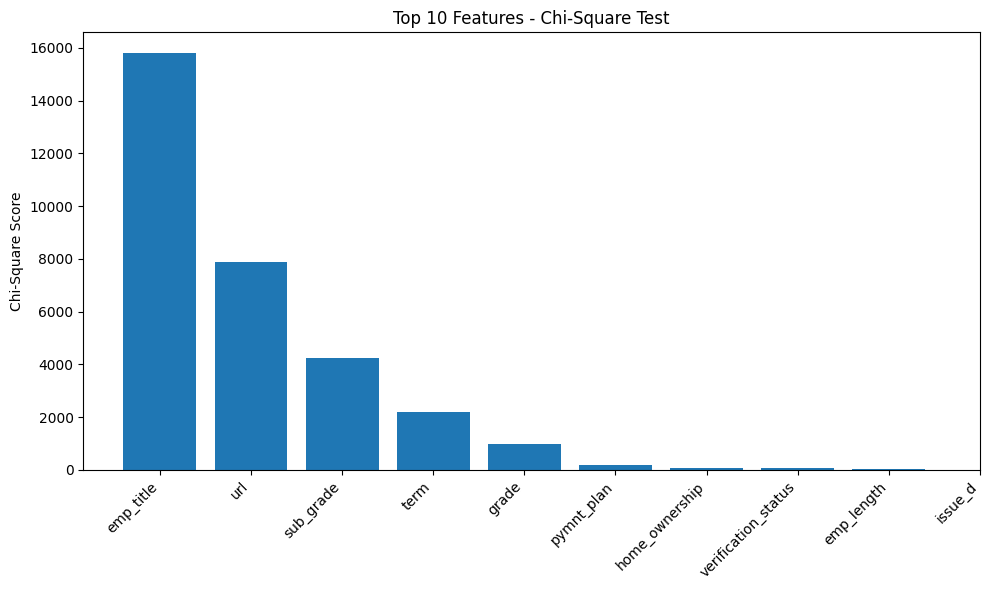

In [4]:
# Chi-Square Test Implementation
from sklearn.feature_selection import chi2

def apply_chi_square(X, y, k=5):
    """Apply Chi-Square test for categorical features"""
    print("Applying Chi-Square test for categorical features...")
    
    selector = SelectKBest(score_func=chi2, k=min(k, X.shape[1]))
    selector.fit(X, y)
    
    results_df = pd.DataFrame({
        'feature': X.columns,
        'chi2_score': selector.scores_,
        'selected': selector.get_support()
    }).sort_values('chi2_score', ascending=False)
    
    selected_features = results_df[results_df['selected']]['feature'].tolist()
    
    print(f"Selected {len(selected_features)} features")
    print("\nTop features:")
    for idx, row in results_df.head(5).iterrows():
        print(f"  {row['feature']}: Chi2 = {row['chi2_score']:.2f}")
    
    return selected_features, results_df, selector

# Apply Chi-Square if data available
if not df.empty and target_column:
    cat_features = df.select_dtypes(include=['object']).columns.tolist()
    if target_column in cat_features:
        cat_features.remove(target_column)
    
    if len(cat_features) >= 3:
        # Encode categorical features
        X_cat = df[cat_features[:10]].copy()
        for col in X_cat.columns:
            le = LabelEncoder()
            X_cat[col] = le.fit_transform(X_cat[col].fillna('Unknown'))
        
        le = LabelEncoder()
        y = le.fit_transform(df[target_column].fillna('Unknown'))
        
        sel_chi, chi_results, chi_sel = apply_chi_square(X_cat, y, k=5)
        
        # Visualize
        plt.figure(figsize=(10, 6))
        top10 = chi_results.head(10)
        plt.bar(range(len(top10)), top10['chi2_score'])
        plt.xticks(range(len(top10)), top10['feature'], rotation=45, ha='right')
        plt.title('Top 10 Features - Chi-Square Test')
        plt.ylabel('Chi-Square Score')
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough categorical features")
        sel_chi = []
else:
    sel_chi = []

## Wrapper Methods
### Recursive Feature Elimination (RFE)
Backward elimination using model weights

Applying RFE with Logistic Regression...
Selected 8 features

Selected features:
  loan_amnt
  funded_amnt
  funded_amnt_inv
  int_rate
  installment


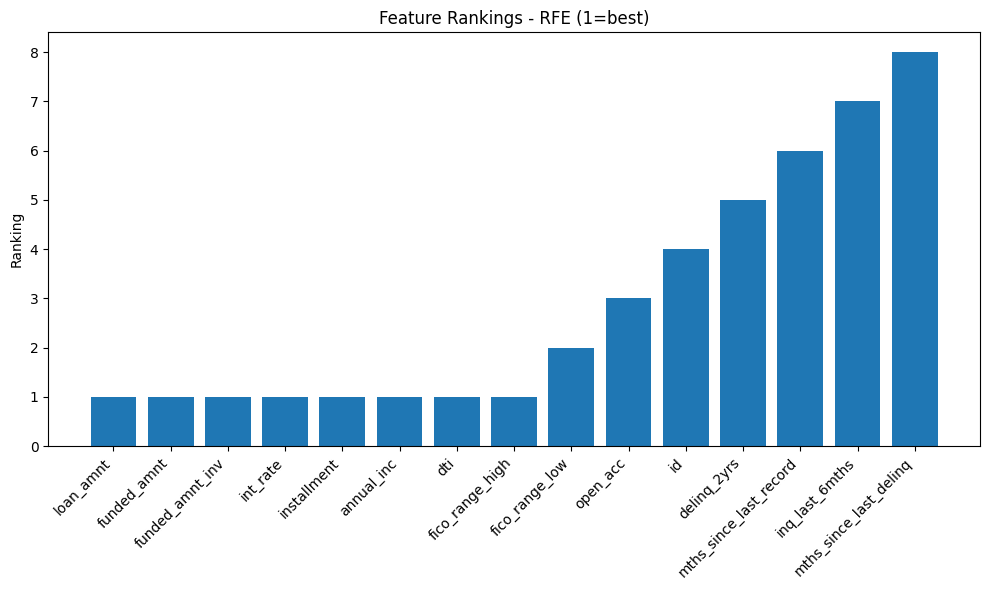

In [5]:
# RFE Implementation
from sklearn.feature_selection import RFE

def apply_rfe(X, y, n_features=10):
    """Apply Recursive Feature Elimination"""
    print("Applying RFE with Logistic Regression...")
    
    estimator = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
    selector = RFE(estimator, n_features_to_select=min(n_features, X.shape[1]), step=1)
    selector.fit(X, y)
    
    rankings = pd.DataFrame({
        'feature': X.columns,
        'ranking': selector.ranking_,
        'selected': selector.get_support()
    }).sort_values('ranking')
    
    selected = rankings[rankings['selected']]['feature'].tolist()
    
    print(f"Selected {len(selected)} features")
    print("\nSelected features:")
    for f in selected[:5]:
        print(f"  {f}")
    
    return selected, rankings, selector

# Apply RFE
if not df.empty and target_column:
    num_features = df.select_dtypes(include=[np.number]).columns.tolist()
    num_features = [c for c in num_features if c != target_column and not c.endswith('_id')]
    
    if len(num_features) >= 5:
        X_rfe = df[num_features[:15]].fillna(df[num_features[:15]].mean())
        scaler = StandardScaler()
        X_rfe = pd.DataFrame(scaler.fit_transform(X_rfe), columns=X_rfe.columns)
        
        le = LabelEncoder()
        y = le.fit_transform(df[target_column].fillna('Unknown'))
        if len(np.unique(y)) > 2:
            y = (y == y[0]).astype(int)
        
        sel_rfe, rfe_rank, rfe_sel = apply_rfe(X_rfe, y, n_features=8)
        
        # Visualize rankings
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(rfe_rank)), rfe_rank['ranking'])
        plt.xticks(range(len(rfe_rank)), rfe_rank['feature'], rotation=45, ha='right')
        plt.title('Feature Rankings - RFE (1=best)')
        plt.ylabel('Ranking')
        plt.tight_layout()
        plt.show()
    else:
        sel_rfe = []
else:
    sel_rfe = []

## Embedded Methods
### Random Forest Feature Importance
Model-based selection using impurity decrease

Applying Random Forest feature importance...
Selected 10 features

Top features:
  int_rate: 0.2296
  installment: 0.1565
  dti: 0.0836
  funded_amnt_inv: 0.0763
  loan_amnt: 0.0721


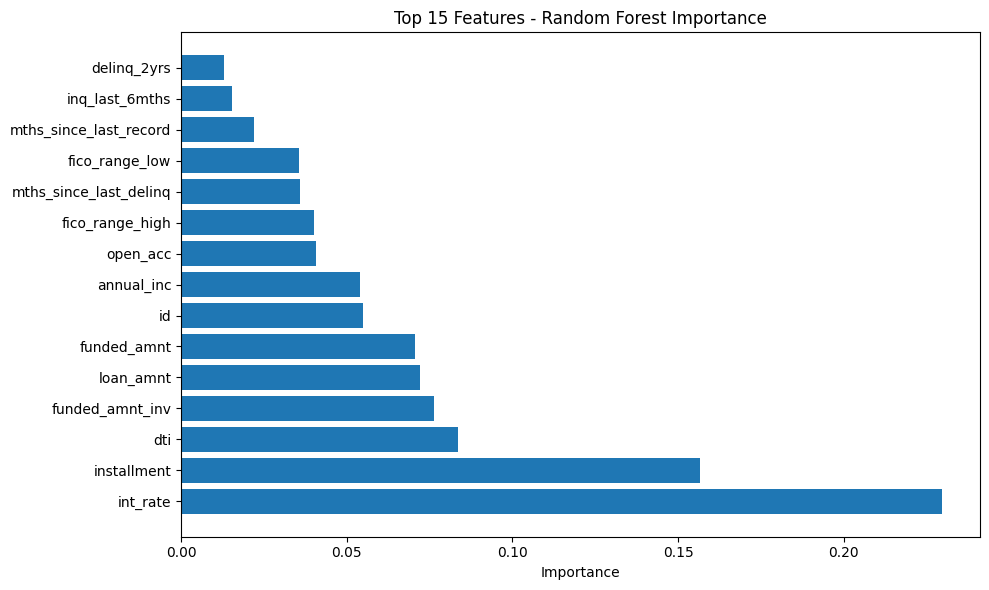

In [6]:
# Random Forest Feature Importance
from sklearn.ensemble import RandomForestClassifier

def apply_rf_importance(X, y, n_features=10):
    """Apply Random Forest feature selection"""
    print("Applying Random Forest feature importance...")
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    rf.fit(X, y)
    
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    selected = importance_df.head(n_features)['feature'].tolist()
    
    print(f"Selected {len(selected)} features")
    print("\nTop features:")
    for idx, row in importance_df.head(5).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    return selected, importance_df, rf

# Apply Random Forest
if not df.empty and target_column:
    num_features = df.select_dtypes(include=[np.number]).columns.tolist()
    num_features = [c for c in num_features if c != target_column and not c.endswith('_id')]
    
    if len(num_features) >= 5:
        X_rf = df[num_features[:15]].fillna(df[num_features[:15]].mean())
        
        le = LabelEncoder()
        y = le.fit_transform(df[target_column].fillna('Unknown'))
        if len(np.unique(y)) > 2:
            y = (y == y[0]).astype(int)
        
        sel_rf, rf_imp, rf_model = apply_rf_importance(X_rf, y, n_features=10)
        
        # Visualize
        plt.figure(figsize=(10, 6))
        top15 = rf_imp.head(15)
        plt.barh(range(len(top15)), top15['importance'])
        plt.yticks(range(len(top15)), top15['feature'])
        plt.title('Top 15 Features - Random Forest Importance')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
    else:
        sel_rf = []
else:
    sel_rf = []

## Comparison of Methods
Compare results from different feature selection approaches

In [7]:
# Compare all methods
print("=== Feature Selection Methods Comparison ===\n")

methods_summary = []

if sel_anova:
    methods_summary.append({'Method': 'ANOVA F-test', 
                           'Count': len(sel_anova),
                           'Top_3': ', '.join(sel_anova[:3])})

if sel_chi:
    methods_summary.append({'Method': 'Chi-Square', 
                           'Count': len(sel_chi),
                           'Top_3': ', '.join(sel_chi[:3])})

if sel_rfe:
    methods_summary.append({'Method': 'RFE', 
                           'Count': len(sel_rfe),
                           'Top_3': ', '.join(sel_rfe[:3])})

if sel_rf:
    methods_summary.append({'Method': 'Random Forest', 
                           'Count': len(sel_rf),
                           'Top_3': ', '.join(sel_rf[:3])})

if methods_summary:
    summary_df = pd.DataFrame(methods_summary)
    print(summary_df.to_string(index=False))
    
    print("\n=== Recommendations ===")
    print("ANOVA F-test: Best for linear relationships (numerical features)")
    print("Chi-Square: Best for categorical features")
    print("RFE: Considers feature interactions")
    print("Random Forest: Captures non-linear patterns")
    print("\nBest practice: Combine multiple methods for robust selection")
else:
    print("No methods completed successfully")

=== Feature Selection Methods Comparison ===

       Method  Count                                   Top_3
 ANOVA F-test     10        int_rate, loan_amnt, funded_amnt
   Chi-Square      5               emp_title, url, sub_grade
          RFE      8 loan_amnt, funded_amnt, funded_amnt_inv
Random Forest     10              int_rate, installment, dti

=== Recommendations ===
ANOVA F-test: Best for linear relationships (numerical features)
Chi-Square: Best for categorical features
RFE: Considers feature interactions
Random Forest: Captures non-linear patterns

Best practice: Combine multiple methods for robust selection
